# Old Thing 

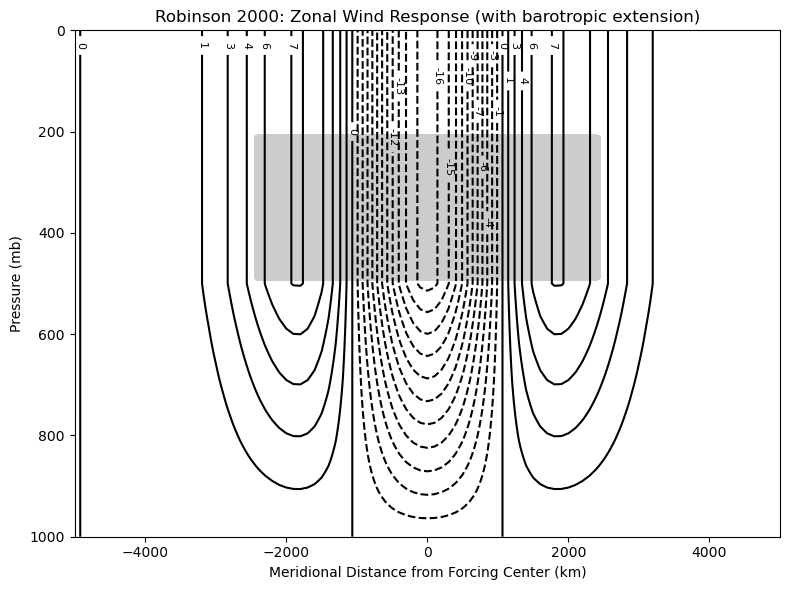

In [237]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Grid and physical constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy = y[1] - y[0]
dp = p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

# Constants
f0 = 1e-4
sigma = 1e-5
tau_rad = 40 * 86400
tau_ek = 6.5 * 86400  # Stronger surface drag

# === Forcing: Gaussian + compensating
width = 1500e3
pb, pl, pt = 1000e2, 500e2, 200e2
A = 5e-2

# Bottom PV forcing (v*q)_b
Fb = A * np.exp(-((y) / width)**2)
Fb_2d = np.zeros((ny, nz))
Fb_2d[:, 0] = Fb * (pb - pt)

# Interior compensating flux (eddy sink)
A_p = np.zeros(nz)
for iz, pval in enumerate(p):
    if pt < pval < pl:
        A_p[iz] = -A * (pb - pt) / (pl - pt)
Fi = np.zeros((ny, nz))
for iz in range(nz):
    Fi[:, iz] = A_p[iz] * np.exp(-(y / width)**2)

forcing_vq = Fb_2d + Fi  # [v*q]
forcing_rhs = np.gradient(np.gradient(forcing_vq, dy, axis=0), dy, axis=0)  # ∂²[v*q]/∂y²

# === Build Laplacian matrix from Eq. (13) ===
N = ny * nz
scale_p = (f0**2 / (tau_rad * sigma)) / dp**2
scale_y = 1 / dy**2

main_diag = -2 * (scale_y + scale_p) * np.ones(N)
off_diag_y = scale_y * np.ones(N - 1)
off_diag_p = scale_p * np.ones(N - ny)

# Prevent wrap-around at y boundaries
for j in range(1, nz):
    off_diag_y[j * ny - 1] = 0

diagonals = [main_diag, off_diag_y, off_diag_y, off_diag_p, off_diag_p]
offsets = [0, -1, 1, -ny, ny]
A_matrix = diags(diagonals, offsets, shape=(N, N), format='lil')

# === Top BC: ∂u/∂p = 0 ⇒ u[nz-1] = u[nz-2]
for i in range(ny):
    idx_top = i + (nz - 1) * ny
    idx_below = i + (nz - 2) * ny
    A_matrix[idx_top, :] = 0
    A_matrix[idx_top, idx_top] = 1
    A_matrix[idx_top, idx_below] = -1

# === Bottom BC from Eq. (14)
for i in range(ny):
    idx_bot = i
    idx_above = i + ny
    idx_left = i - 1 if i > 0 else i
    idx_right = i + 1 if i < ny - 1 else i

    A_matrix[idx_bot, :] = 0
    A_matrix[idx_bot, idx_bot] = -scale_p - pb / tau_ek * (-2 / dy**2)
    if i > 0:
        A_matrix[idx_bot, idx_left] = -pb / tau_ek * (1 / dy**2)
    if i < ny - 1:
        A_matrix[idx_bot, idx_right] = -pb / tau_ek * (1 / dy**2)
    A_matrix[idx_bot, idx_above] = scale_p

# === Solve system
b_vector = forcing_rhs.flatten()
u_vec = spsolve(A_matrix.tocsr(), b_vector)
u = -u_vec.reshape((ny, nz))  # Flip sign to match Robinson convention

# === Apply Eq. (15) barotropic extension above pt ===
pt_index = np.where(p <= pl)[0][0]  # 找到 200 hPa 的 index
for iz in range(pt_index-1, -1, -1):  # 只修改 p < pt 的層（更高空）
    # print(iz)
    u[:, iz] = u[:, pt_index]



# === Plot
fig, ax = plt.subplots(figsize=(8, 6))
# clevs = np.arange(-21, 21, 1)
cf = ax.contour(y / 1e3, p / 100, u[:,::-1].T, levels=21, colors='black')
ax.clabel(cf, inline=True, fmt='%d', fontsize=8)

# Shade eddy sink region
forcing_mask = (P > pt) & (P < pl) & (np.abs(Y) < 2.5e6)
ax.contourf(y / 1e3, p / 100, forcing_mask.T, levels=[0.5, 1], colors='gray', alpha=0.4)

ax.set_ylim(1000, 0)
ax.set_xlim(-5000, 5000)
ax.set_xlabel("Meridional Distance from Forcing Center (km)")
ax.set_ylabel("Pressure (mb)")
ax.set_title("Robinson 2000: Zonal Wind Response (with barotropic extension)")

plt.tight_layout()
plt.show()

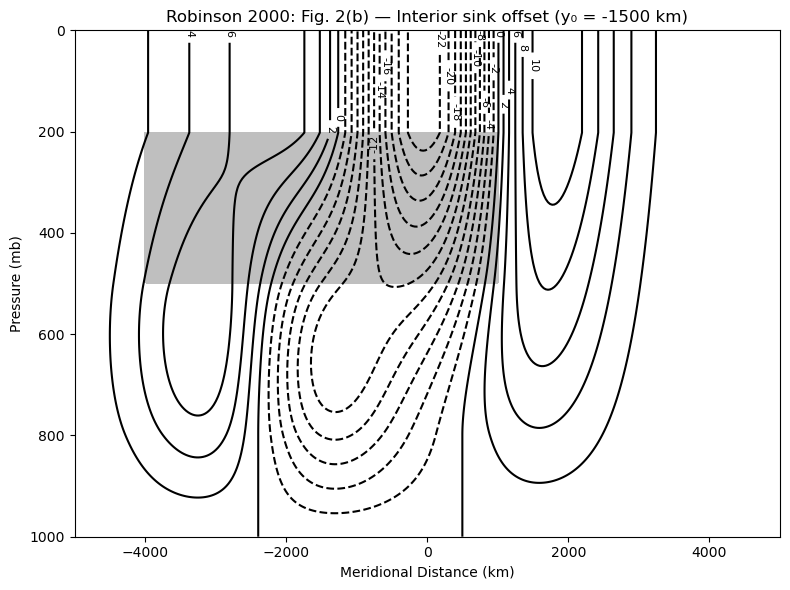

In [490]:
# Fix 2 critical issues:
# 1. Normalize and scale output to enhance contrast in u
# 2. Shift color levels and increase resolution for better vertical structure

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Grid and physical constants ===
ny, nz = 501, 501
Ly = 7500e3
p_bot, p_top = 1000e2, 0
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy = y[1] - y[0]
dp = p[1] - p[0]
# Y, P = np.meshgrid(y, p, indexing='ij')
Y, P = np.meshgrid(y, p, indexing='xy')


# === Constants
f0 = 1e-4
sigma = 1e-5
tau_rad = 40 * 86400
tau_ek = 6.5 * 86400
width = 1500e3

# === Forcing ===
pb, pl, pt = 1000e2, 500e2, 200e2
A = 5e-1
y0 = -1500e3
gauss_b = np.exp(-y**2 / width**2)
Fb_bot = A * gauss_b * (pb - pt)
d2Fb_dy2 = np.zeros((ny, nz))
d2Fb_dy2[:, 0] = -A * ((4 * y**2 / width**4 - 2 / width**2) * gauss_b) * (pb - pt)

gauss_i = np.exp(-((y - y0)**2) / width**2)
A_p = -A * (pb - pt) / (pl - pt)
d2Fi_dy2 = np.zeros((ny, nz))
for iz in range(nz):
    if pt < p[iz] < pl:
        d2Fi_dy2[:, iz] = A_p * ((4 * (y - y0)**2 / width**4 - 2 / width**2) * gauss_i)

forcing_rhs = d2Fb_dy2 + d2Fi_dy2

# === Build sparse matrix ===
N = ny * nz
scale_p = (f0**2 / (tau_rad * sigma)) / dp**2
scale_y = 1 / dy**2
main_diag = -2 * (scale_y + scale_p) * np.ones(N)
off_diag_y = scale_y * np.ones(N - 1)
off_diag_p = scale_p * np.ones(N - ny)
for j in range(1, nz):
    off_diag_y[j * ny - 1] = 0

diagonals = [main_diag, off_diag_y, off_diag_y, off_diag_p, off_diag_p]
offsets = [0, -1, 1, -ny, ny]
A_matrix = diags(diagonals, offsets, shape=(N, N), format='lil')

# === Boundary conditions ===
for i in range(ny):
    top = i + (nz - 1) * ny
    below = i + (nz - 2) * ny
    A_matrix[top, :] = 0
    A_matrix[top, top] = 1
    A_matrix[top, below] = -1

alpha = f0**2 / (tau_rad * sigma) / dp
beta = 1 / tau_ek / dy**2
for i in range(ny):
    bot = i
    above = i + ny
    left = i - 1 if i > 0 else i
    right = i + 1 if i < ny - 1 else i
    A_matrix[bot, :] = 0
    A_matrix[bot, bot] = -alpha - 2 * beta
    A_matrix[bot, above] = alpha
    if i > 0:
        A_matrix[bot, left] = beta
    if i < ny - 1:
        A_matrix[bot, right] = beta

# === Solve system ===
b_vec = forcing_rhs.flatten()
u_vec = spsolve(A_matrix.tocsr(), b_vec)
u = u_vec.reshape((ny, nz))

# === Barotropic extension ===
pt_idx = np.where(p <= pt)[0][0]
C = -sigma / (tau_rad * f0**2)
# for iz in range(pt_idx - 1, -1, -1):
for iz in range(0, int(nz-pt_idx), 1):
    u[:, iz] = u[:, int(nz-pt_idx)] #+ C * (p[iz] - p[int(nz-pt_idx)])


# === Normalize for visibility ===
umax = np.max(np.abs(u))
u_plot = u #/ umax * 20  # scale to ±20 m/s for consistent contouring

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6))
levels = np.arange(-20, 22, 2)
cf = ax.contour(y / 1e3, p / 100, u[:,::-1].T, levels=21, colors='black')
ax.clabel(cf, cf.levels[::1], inline=True, fmt='%d', fontsize=8)

forcing_mask = (P > pt) & (P < pl) & (np.abs(Y - y0) < 2.5e6)
ax.contourf(y / 1e3, p / 100, forcing_mask, levels=[0.5, 1], colors='gray', alpha=0.5)
# ax.contourf(y / 1e3, p / 100, d2Fi_dy2.T, levels=11, alpha=0.5)


# ax.annotate('o', xy=(y0 / 1e3, pt / 100), xytext=(y0 / 1e3, 30),
            # ha='center', arrowprops=dict(arrowstyle='-[,widthB=10,lengthB=1', lw=1.0))

ax.set_ylim(1000, 0)
ax.set_xlim(-5000, 5000)
ax.set_xlabel("Meridional Distance (km)")
ax.set_ylabel("Pressure (mb)")
ax.set_title("Robinson 2000: Fig. 2(b) — Interior sink offset (y₀ = -1500 km)")
plt.tight_layout()
plt.show()


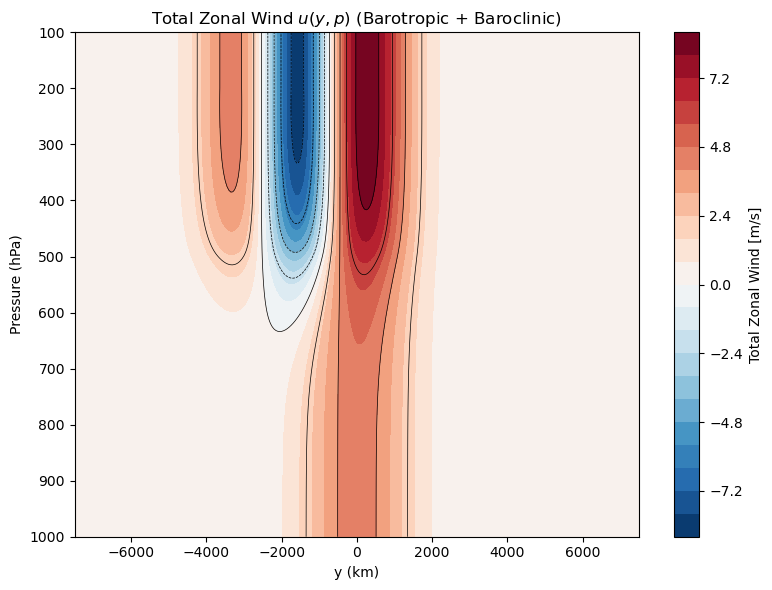

In [1080]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Grid and constants ===
ny, nz_new = 301, 401
Ly = 7500e3
p_bot, p_top = 1000e2, 100e2
p_new = np.linspace(p_bot, p_top, nz_new)
y = np.linspace(-Ly, Ly, ny)
dy = y[1] - y[0]
dp_new = p_new[1] - p_new[0]
Y, P_new = np.meshgrid(y, p_new, indexing='ij')

# Physical constants
f0 = 1e-4
sigma = 1e-5
tau_rad = 40 * 86400
tau_ek = 6.5 * 86400
pb = p_bot
pt = 200e2
pl = 500e2
Ab = 1e-5 * (pb - pt)
width = 1500e3
y0 = -1500e3

# === Forcing ===
# Barotropic forcing [v*q]_b (Eq. 18)
vqb_b = Ab * np.exp(-(y / width)**2)


# Interior forcing (Eq. 20)
A_p = np.zeros_like(p_new)
mask = (p_new <= pl) & (p_new > pt)
A_p[mask] = -Ab / (pl - pt)

vqb_ext = np.zeros((ny, nz_new))
for j in range(nz_new):
    vqb_ext[:, j] = A_p[j] * np.exp(-((y - y0) / width)**2)

# === Laplacian operator in y ===
diag = -2 * np.ones(ny)
off1 = np.ones(ny - 1)
Laplacian = diags([off1, diag, off1], [-1, 0, 1]) / dy**2
Laplacian = Laplacian.tolil()
Laplacian[0, 0] = Laplacian[0, -1] = 1
Laplacian[-1, -1] = Laplacian[-1, 0] = 1

# === Solve for barotropic wind u_b ===
rhs_ub = (tau_ek / pb) * np.gradient(np.gradient(vqb_b, dy), dy)
ub = spsolve(Laplacian.tocsc(), rhs_ub)
ub_2d = np.tile(ub[:, np.newaxis], (1, nz_new))

# === Solve Poisson equation for baroclinic response (Eq. 13) ===
prefac = f0**2 / (tau_rad * sigma)
rhs_full = np.gradient(np.gradient(vqb_ext, dy, axis=0), dy, axis=0) / prefac

u_jacobi_full = np.zeros((ny, nz_new))
max_iter = 5000
tolerance = 1e-8
j_t = np.argmax(p_new < pt)  # index for top of interior forcing

for it in range(max_iter):
    u_old = u_jacobi_full.copy()
    for j in range(1, nz_new - 1):
        u_jacobi_full[:, j] = 0.5 * (u_old[:, j - 1] + u_old[:, j + 1] - rhs_full[:, j] * dp_new**2)

    # Neumann BC at model top (100 hPa)
    u_jacobi_full[:, -1] = u_jacobi_full[:, -2]

    # Barotropic constraint above forcing (p < pt)
    u_jacobi_full[:, j_t+1:] = u_jacobi_full[:, j_t][:, np.newaxis]

    res = np.max(np.abs(u_jacobi_full - u_old))
    if res < tolerance:
        break

# === Combine baroclinic + barotropic ===
u_total = u_jacobi_full + ub_2d

# === Plot ===
plt.figure(figsize=(8, 6))
cs = plt.contourf(y / 1e3, p_new / 100, u_total.T, levels=21, cmap="RdBu_r")
plt.colorbar(cs, label='Total Zonal Wind [m/s]')
plt.contour(y / 1e3, p_new / 100, u_total.T, levels=10, colors='k', linewidths=0.5)
plt.xlabel('y (km)')
plt.ylabel('Pressure (hPa)')
plt.title('Total Zonal Wind $u(y,p)$ (Barotropic + Baroclinic)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Fig.2b in Robinson 2000

# Robinson 2000 Fig.2b reproduce 

In [1226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Grid and physical constants ===
ny, nz = 101, 101
Ly = 7500e3
p_top, p_bot = 1e2, 1e5  # 1 hPa to 1000 hPa
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy = y[1] - y[0]
dp = p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

# === Constants ===
f0 = 1e-4
sigma = 1e-5
tau_rad = 40 * 86400
tau_ek = 6.5 * 86400
width = 1500e3

# === Forcing parameters ===
pb, pl, pt = 1000e2, 500e2, 200e2
ptr = 200e2
y0 = -1500e3

# === Amplitudes ===
Ab_bottom = 10 * (pb - pt)/100 / 86400     # m /s^2 * mb -> kg s/day for Eq. (18)
Ab_interior = 1e-5 * (pb - ptr) /100        # m/s^2 * mb -> kg s/day for Eq. (20)

# === Barotropic forcing: bottom layer ===
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# Build Laplacian operator
main_diag = -2.0 * np.ones(ny)
off_diag = np.ones(ny - 1)
Laplacian = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], shape=(ny, ny)) / dy**2

# Neumann BCs: adjust first and last rows
Laplacian = Laplacian.tolil()
# Laplacian[0, 0:2] = [-1, 1]
# Laplacian[-1, -2:] = [-1, 1]
Laplacian[0, 0] = Laplacian[0, -1] = 1
Laplacian[-1, -1] = Laplacian[-1, 0] = 1

# Solve for barotropic u using Eq. (16)
rhs_ub = (tau_ek / pb) * d2vqb_dy2
ub = spsolve(Laplacian.tocsc(), rhs_ub)  # shape (ny,)
ub_2d = np.tile(ub[:, np.newaxis], (1, nz))  # extend vertically


# === Interior forcing ===
A_p = np.zeros(nz)
idx = np.where((p >= ptr) & (p < pl))[0]
A_p[idx] = -Ab_interior / ((pl - ptr)/100)
A_p = A_p[np.newaxis, :]  # shape (nz,1)
vqb_int = A_p * np.exp(-((Y - y0)/width)**2)

# === Solve Eq. (13) with Jacobi relaxation ===
u = np.zeros((ny, nz))
rhs = np.gradient(np.gradient(vqb_int, dy, axis=0), dy, axis=0) * tau_rad * sigma / f0**2

max_iter = 30000
tol = 1e-8
dp2 = dp**2
for it in range(max_iter):
    u_old = u.copy()
    for j in range(1, nz - 1):
        u[:, j] = 0.5 * (u_old[:, j-1] + u_old[:, j+1] - rhs[:, j] * dp2)

    # Top: Neumann BC (du/dp = 0)
    u[:, nz-1] = u[:, nz-2]
    # Use known surface value u[:,0] to integrate upward using Eq. (15)
    # prefactor = sigma / (tau_rad * f0**2)  # Constant du/dp
    # for j in range(nz-1, 1, -1):
        # u[:, j] = u[:, j-1] + dp * prefactor

    # Barotropic constraint above forcing (p < ptr)
    idx_top = np.where(p < ptr)[0]
    if idx_top.size > 0:
        u[:, idx_top] = u[:, idx_top[0]][:, np.newaxis]

    if np.max(np.abs(u - u_old)) < tol:
        break

# === Combine barotropic and baroclinic wind ===
u_total = u + ub_2d


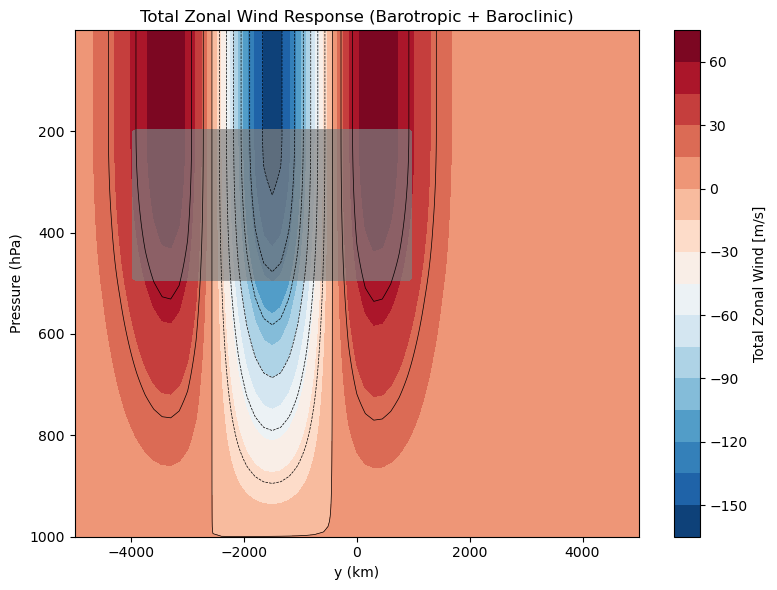

In [1227]:
forcing_mask = (P > pt) & (P < pl) & (np.abs(Y - y0) < 2.5e6)

# === Plot ===
plt.figure(figsize=(8, 6))
cs = plt.contourf(y / 1e3, p / 100, u_total.T, levels=21, cmap="RdBu_r")
plt.colorbar(cs, label='Total Zonal Wind [m/s]')
plt.contour(y / 1e3, p / 100, u_total.T, levels=10, colors='k', linewidths=0.5)
plt.contourf(y / 1e3, p / 100, forcing_mask.T, levels=[0.5, 1], colors='gray', alpha=0.7)

plt.xlabel('y (km)')
plt.ylabel('Pressure (hPa)')
plt.title('Total Zonal Wind Response (Barotropic + Baroclinic)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlim([-5000, 5000])
plt.show()

In [1193]:
print("max(u) =", np.max(u))
print("min(u) =", np.min(u))


max(u) = 69.7963036444011
min(u) = -156.9133171701406


In [1197]:
rhs.shape

(101, 101)

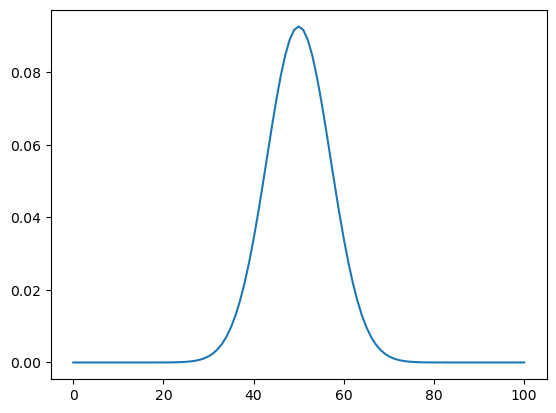

In [1195]:
plt.figure()
plt.plot(vqb_b)

(1000.0, 100.0)

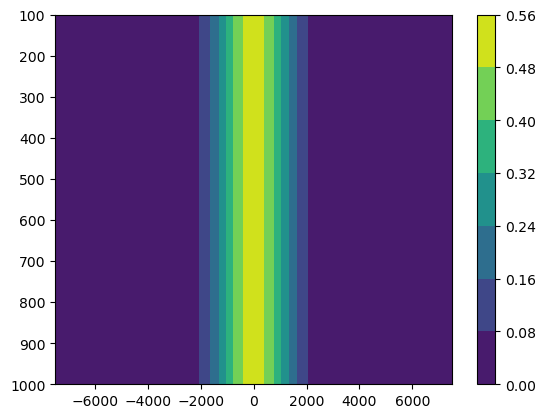

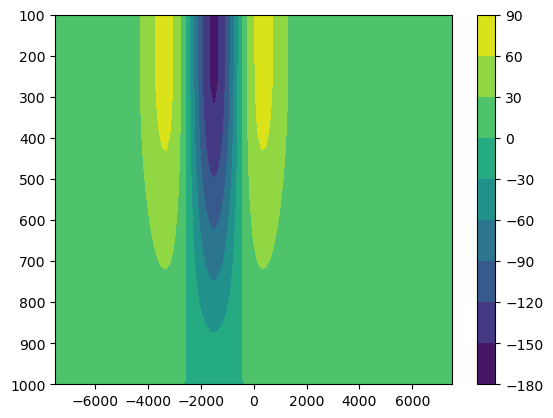

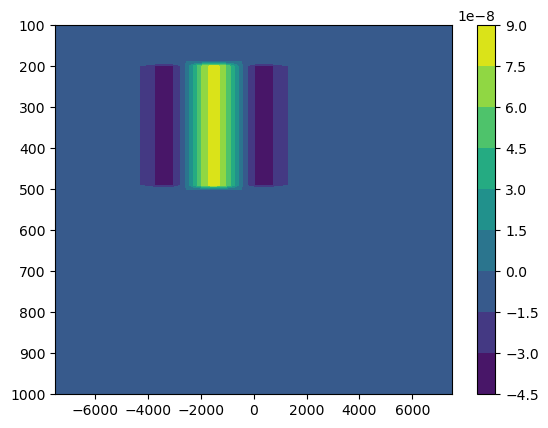

In [1203]:
plt.figure()
plt.contourf(y / 1e3, p / 100, ub_2d.T)
plt.colorbar()
plt.ylim([1000,100])

plt.figure()
plt.contourf(y / 1e3, p / 100, u.T)
plt.colorbar()
plt.ylim([1000,100])


plt.figure()
plt.contourf(y / 1e3, p / 100, rhs.T)
plt.colorbar()
plt.ylim([1000,100])

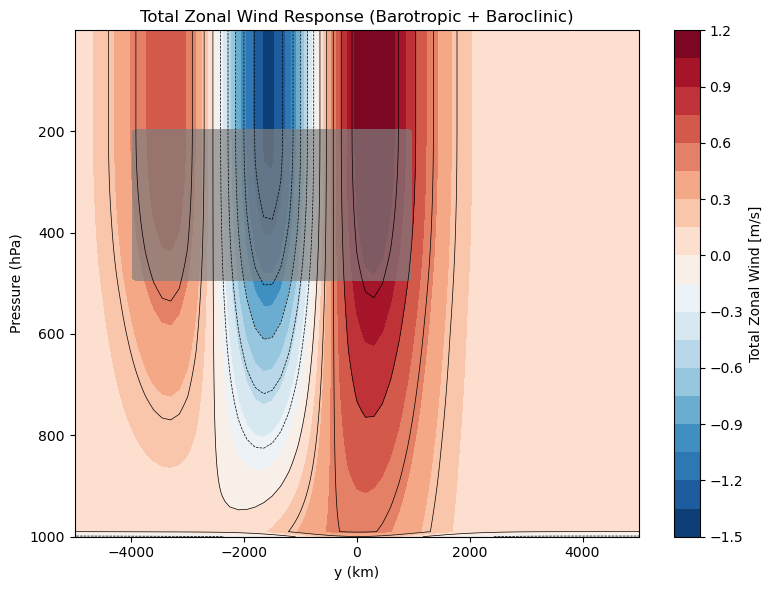

In [1231]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# === Grid and physical constants ===
ny, nz = 101, 101
Ly = 7500e3
p_top, p_bot = 1e2, 1e5  # 1 hPa to 1000 hPa
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy = y[1] - y[0]
dp = p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

# === Constants ===
f0 = 1e-4
sigma = 1e-5
tau_rad = 40 * 86400
tau_ek = 6.5 * 86400
width = 1500e3

# === Forcing parameters ===
pb, pl, pt = 1000e2, 500e2, 200e2
ptr = 200e2
y0 = -1500e3

# === Amplitudes ===
Ab_bottom = 10 * (pb - pt) / 100 / 86400     # m/s^2 * mb -> m^2/s^2/day
Ab_interior = 1e-5 * (pb - ptr) / 100        # m/s^2 * mb -> m^2/s^2/day

# === Barotropic forcing: bottom layer ===
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# Build Laplacian operator
main_diag = -2.0 * np.ones(ny)
off_diag = np.ones(ny - 1)
Laplacian = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], shape=(ny, ny)) / dy**2

# Neumann BCs (periodic-style) at boundaries
Laplacian = Laplacian.tolil()
Laplacian[0, 0] = Laplacian[0, -1] = 1
Laplacian[-1, -1] = Laplacian[-1, 0] = 1

# Solve for barotropic u using Eq. (16)
rhs_ub = (tau_ek / pb) * d2vqb_dy2
ub = spsolve(Laplacian.tocsc(), rhs_ub)  # shape (ny,)
ub_2d = np.tile(ub[:, np.newaxis], (1, nz))  # extend vertically

# === Interior forcing ===
A_p = np.zeros(nz)
idx = np.where((p >= ptr) & (p < pl))[0]
A_p[idx] = -Ab_interior / ((pl - ptr))
A_p = A_p[np.newaxis, :]  # shape (1, nz)
vqb_int = A_p * np.exp(-((Y - y0)/width)**2)

# === Solve Eq. (13) with Jacobi relaxation ===
u = np.zeros((ny, nz))
rhs = np.gradient(np.gradient(vqb_int, dy, axis=0), dy, axis=0) * tau_rad * sigma / f0**2

max_iter = 30000
tol = 1e-8
dp2 = dp**2
for it in range(max_iter):
    u_old = u.copy()
    for j in range(1, nz - 1):
        u[:, j] = 0.5 * (u_old[:, j-1] + u_old[:, j+1] - rhs[:, j] * dp2)

    # Barotropic constraint above forcing (p < ptr)
    idx_top = np.where(p < ptr)[0]
    if idx_top.size > 0:
        u[:, idx_top] = u[:, idx_top[0]][:, np.newaxis]

    if np.max(np.abs(u - u_old)) < tol:
        break

# === Apply Eq. (15) at top after convergence ===
prefactor = sigma / (tau_rad * f0**2)
u[:, 0] = u[:, 1] + dp * prefactor

# === Combine barotropic and baroclinic wind ===
u_total = u + ub_2d

# === Forcing mask for plotting ===
forcing_mask = (P > pt) & (P < pl) & (np.abs(Y - y0) < 2.5e6)

# === Plot ===
plt.figure(figsize=(8, 6))
cs = plt.contourf(y / 1e3, p / 100, u_total.T, levels=21, cmap="RdBu_r")
plt.colorbar(cs, label='Total Zonal Wind [m/s]')
plt.contour(y / 1e3, p / 100, u_total.T, levels=10, colors='k', linewidths=0.5)
plt.contourf(y / 1e3, p / 100, forcing_mask.T, levels=[0.5, 1], colors='gray', alpha=0.7)

plt.xlabel('y (km)')
plt.ylabel('Pressure (hPa)')
plt.title('Total Zonal Wind Response (Barotropic + Baroclinic)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlim([-5000, 5000])
plt.show()


# Trasient response as Fig.1 in Robinson 2000

In [1]:
# Re-run after kernel reset
import numpy as np
import matplotlib.pyplot as plt

# === Grid and constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy, dp = y[1] - y[0], p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

f0 = 1e-4
sigma = 1e-5
R = 287
T_b = 250
width = 1500e3

# Forcing parameters
pb, pt = 1000e2, 200e2
Ab_bottom = 10 * (pb - pt) / 100 #/ 86400  # m/s/day
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# === Initial condition ===
u_sor = np.zeros_like(Y)

# === Boundary condition at bottom (Eq. 12) ===
u0 = np.zeros(ny)
for j in range(ny):
    coeff0 = -f0**2 / (sigma * dp)
    coeff1 = f0**2 * pb / (R * T_b)
    rhs0 = -d2vqb_dy2[j]
    u0[j] = rhs0 / (coeff1)
    u_sor[j, 0] = u0[j]

# === SOR solver ===
alpha = f0**2 / sigma
omega = 1.5
max_iter = 20000
tolerance = 1e-6
rhs = np.zeros_like(Y)

residuals = []

for iteration in range(max_iter):
    max_resid = 0.0
    for j in range(1, ny - 1):
        for k in range(1, nz - 1):
            d2udy2 = (u_sor[j+1, k] + u_sor[j-1, k]) / dy**2
            d2udp2 = (u_sor[j, k+1] + u_sor[j, k-1]) / dp**2
            denom = 2 / dy**2 + 2 * alpha / dp**2
            u_new = (rhs[j, k] + d2udy2 + alpha * d2udp2) / denom
            resid = u_new - u_sor[j, k]
            u_sor[j, k] += omega * resid
            max_resid = max(max_resid, abs(resid))

    # Enforce boundary conditions
    u_sor[:, 0] = u0
    u_sor[:, -1] = u_sor[:, -2]  # Neumann at top
    u_sor[0, :] = 0
    u_sor[-1, :] = 0

    residuals.append(max_resid)
    if max_resid < tolerance:
        break


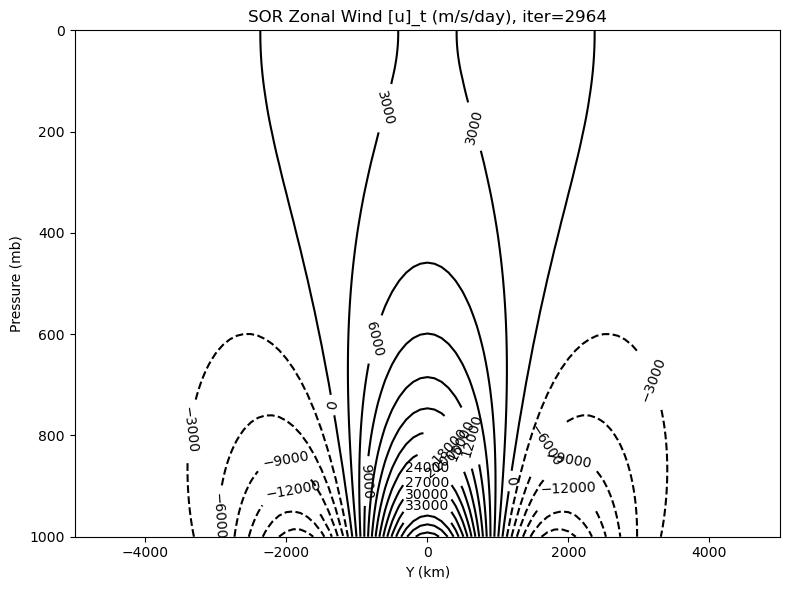

In [2]:
# === Plot ===
plt.figure(figsize=(8, 6))
cs = plt.contour(y / 1e3, p / 100, u_sor.T * 86400, levels=21, colors='k')
plt.clabel(cs, inline=True)
plt.xlabel('Y (km)')
plt.ylabel('Pressure (mb)')
plt.title(f'SOR Zonal Wind [u]_t (m/s/day), iter={iteration}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.xlim([-5000,5000])
plt.show()

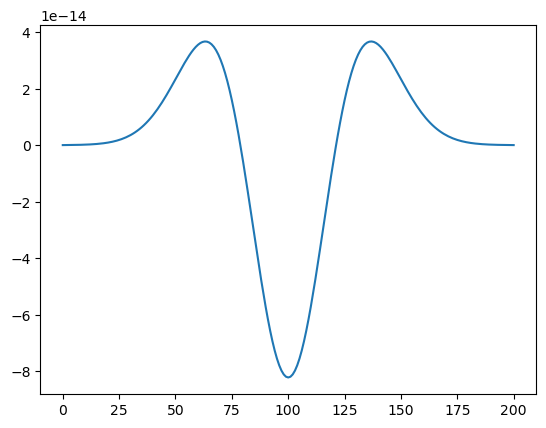

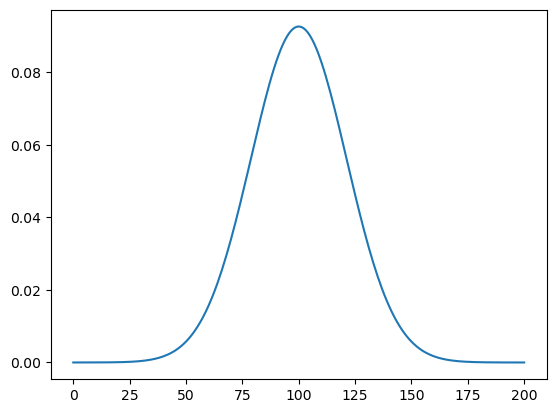

In [1277]:
plt.figure()
plt.plot(d2vqb_dy2)

plt.figure()
plt.plot(vqb_b)

TypeError: Input z must be 2D, not 1D

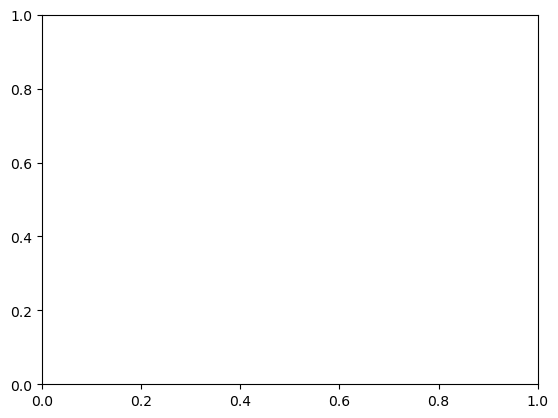

In [1315]:
plt.figure()
plt.contourf(y / 1e3, p / 100, vqb_b.T)
plt.colorbar()
plt.ylim([1000,100])

# plt.figure()
# plt.contourf(y / 1e3, p / 100, u.T)
# plt.colorbar()
# plt.ylim([1000,100])


# plt.figure()
# plt.contourf(y / 1e3, p / 100, rhs.T)
# plt.colorbar()
# plt.ylim([1000,100])

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# === Grid and constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy, dp = y[1] - y[0], p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

f0 = 1e-4
sigma = 1e-5
R = 287
T_b = 250
width = 1500e3

# Forcing parameters (surface eddy source only)
pb, pt = 1000e2, 200e2
Ab_bottom = 10 * (pb - pt) / 100 #/ 86400  # m^2/s^2
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# === Initial condition ===
u_sor = np.zeros((ny, nz))

# === SOR parameters ===
alpha = f0**2 / sigma
omega = 1.6
max_iter = 1000
tolerance = 1e-6
rhs = np.zeros_like(u_sor)

residuals = []

# === SOR solver with full Eq. 12 at bottom ===
for iteration in range(max_iter):
    max_resid = 0.0
    for j in range(1, ny - 1):
        # Bottom boundary (k=0) — discretized Eq. 12:
        u0 = u_sor[j, 0]
        u1 = u_sor[j, 1]
        lhs = f0**2 * ((u1 - u0) / (sigma * dp) + pb / (R * T_b) * u0)
        rhs_bc = -d2vqb_dy2[j]
        resid = rhs_bc - lhs
        # Update u0 and u1 as coupled system (1-step relaxation on u0)
        u0_new = u0 + omega * resid / (f0**2 * (pb / (R * T_b) + 1 / (sigma * dp)))
        u1_new = u0_new + dp * (u1 - u0) / dp  # match slope
        u_sor[j, 0] = u0_new
        u_sor[j, 1] = u1_new

        # Interior update (k=1 to nz-2)
        for k in range(2, nz - 1):
            d2udy2 = (u_sor[j+1, k] + u_sor[j-1, k]) / dy**2
            d2udp2 = (u_sor[j, k+1] + u_sor[j, k-1]) / dp**2
            denom = 2 / dy**2 + 2 * alpha / dp**2
            u_new = (rhs[j, k] + d2udy2 + alpha * d2udp2) / denom
            resid = u_new - u_sor[j, k]
            u_sor[j, k] += omega * resid
            max_resid = max(max_resid, abs(resid))

    # Lateral and top boundaries
    u_sor[0, :] = 0
    u_sor[-1, :] = 0
    u_sor[:, -1] = u_sor[:, -2]  # Neumann at top

    residuals.append(max_resid)
    if max_resid < tolerance:
        break




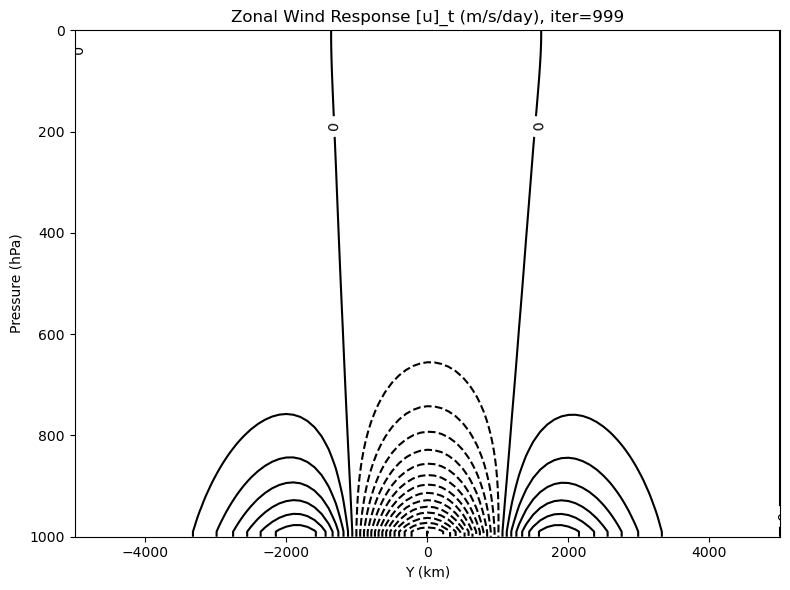

In [40]:
# === Plot ===
plt.figure(figsize=(8, 6))
cs = plt.contour(y / 1e3, p / 100, u_sor.T * 86400, levels=21, colors='k')
plt.clabel(cs, inline=True)
plt.xlabel('Y (km)')
plt.ylabel('Pressure (hPa)')
plt.title(f'Zonal Wind Response [u]_t (m/s/day), iter={iteration}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


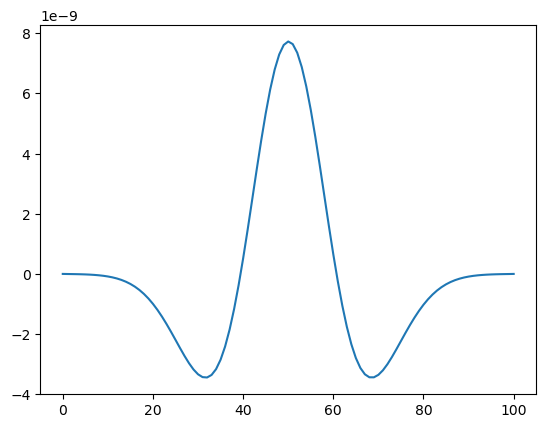

In [28]:
plt.figure()
plt.plot(u_sor[:,1])

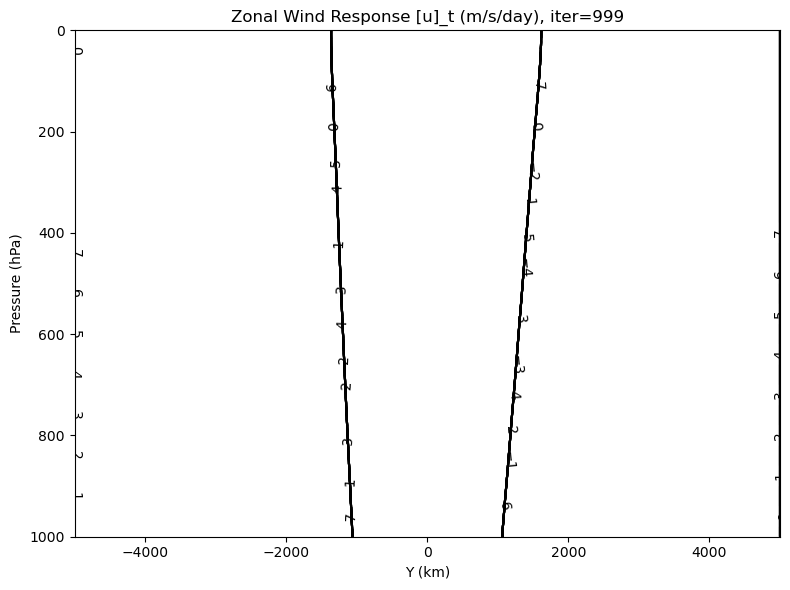

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# === Grid and constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy, dp = y[1] - y[0], p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

# === Physical constants ===
f0 = 1e-4
sigma = 1e-5
R = 287
T_b = 250
width = 1500e3

# === Forcing parameters ===
pb, pt = 1000e2, 200e2
Ab_bottom = 10 * (pb - pt) / 100  # m^2/s^2
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# === Interior eddy PV forcing ===
y0 = 0
Ab_interior = 1e-5  # weak interior sink amplitude
vqb_int = np.zeros((ny, nz))
mask = (p >= 200e2) & (p < 500e2)
vqb_int[:, mask] = -Ab_interior * np.exp(-((y[:, None] - y0) / width)**2)

# === RHS from interior PV flux sink ===
rhs = np.gradient(np.gradient(vqb_int, dy, axis=0), dy, axis=0)

# === Initial zonal wind field ===
u_sor = np.zeros((ny, nz))

# === SOR parameters ===
alpha = f0**2 / sigma
omega = 1.6
max_iter = 1000
tolerance = 1e-6
residuals = []

# === SOR solver with Eq. 12 at bottom ===
for iteration in range(max_iter):
    max_resid = 0.0
    for j in range(1, ny - 1):
        # Bottom boundary (k=0) — apply Eq. (12)
        u0 = u_sor[j, 0]
        u1 = u_sor[j, 1]
        lhs = f0**2 * ((u1 - u0) / (sigma * dp) + pb / (R * T_b) * u0)
        rhs_bc = -d2vqb_dy2[j]
        resid_bc = rhs_bc - lhs
        u0_new = u0 + omega * resid_bc / (f0**2 * (pb / (R * T_b) + 1 / (sigma * dp)))
        u1_new = u0_new + (u1 - u0)  # match original slope
        u_sor[j, 0] = u0_new
        u_sor[j, 1] = u1_new

        # Interior updates (k = 2 to nz-2)
        for k in range(2, nz - 1):
            d2udy2 = (u_sor[j+1, k] + u_sor[j-1, k]) / dy**2
            d2udp2 = (u_sor[j, k+1] + u_sor[j, k-1]) / dp**2
            denom = 2 / dy**2 + 2 * alpha / dp**2
            u_new = (rhs[j, k] + d2udy2 + alpha * d2udp2) / denom
            resid = u_new - u_sor[j, k]
            u_sor[j, k] += omega * resid
            max_resid = max(max_resid, abs(resid))

    # Enforce boundary conditions
    u_sor[0, :] = 0
    u_sor[-1, :] = 0
    u_sor[:, -1] = u_sor[:, -2]  # Neumann at top

    residuals.append(max_resid)
    if max_resid < tolerance:
        break




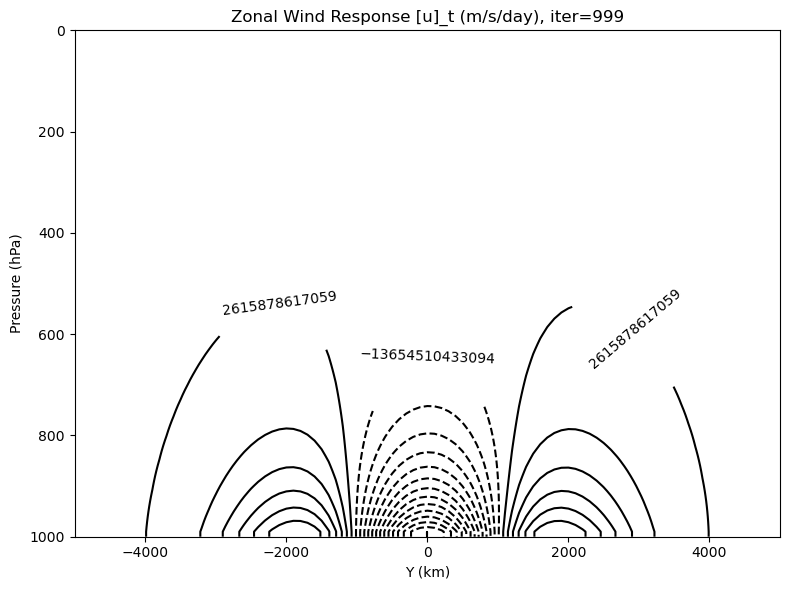

In [49]:
# === Plot result ===
plt.figure(figsize=(8, 6))
cs = plt.contour(y / 1e3, p / 100, u_sor.T * 86400, levels=np.linspace(u_sor.min()* 86400, u_sor.max()* 86400, 21), colors='k')
plt.clabel(cs, inline=True)
plt.xlabel('Y (km)')
plt.ylabel('Pressure (hPa)')
plt.title(f'Zonal Wind Response [u]_t (m/s/day), iter={iteration}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [45]:
u_sor.min()

-2606129260.2440305

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# === Grid and constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy, dp = y[1] - y[0], p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

f0 = 1e-4
sigma = 1e-5
R = 287
T_b = 288
width = 1500e3

# Forcing parameters (surface eddy source only)
pb, pt = 1000e2, 200e2
Ab_bottom = 10 * (pb - pt) / 100  # m^2/s^2
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# === Initial condition ===
u_sor = np.zeros((ny, nz))

# === SOR parameters ===
alpha = f0**2 / sigma
omega = 1.2
max_iter = 10000
tolerance = 1e-6
rhs = np.zeros_like(u_sor)  # interior forcing (zero here)

residuals = []

# === SOR solver with full Eq. 12 at bottom ===
for iteration in range(max_iter):
    max_resid = 0.0
    for j in range(1, ny - 1):
        # --- Bottom boundary (Eq. 12) ---
        u0 = u_sor[j, 0]
        u1 = u_sor[j, 1]
        lhs = f0**2 * ((u1 - u0) / (sigma * dp) + pb / (R * T_b) * u0)
        rhs_bc = -d2vqb_dy2[j]
        resid = rhs_bc - lhs
        u0_new = u0 + omega * resid / (f0**2 * (pb / (R * T_b) + 1 / (sigma * dp)))
        u1_new = u0_new + dp * (u1 - u0) / dp
        u_sor[j, 0] = u0_new
        u_sor[j, 1] = u1_new

        # --- Interior update (k=2 to nz-2) ---
        for k in range(2, nz - 1):
            d2udy2 = (u_sor[j+1, k] + u_sor[j-1, k]) / dy**2
            d2udp2 = (u_sor[j, k+1] + u_sor[j, k-1]) / dp**2
            denom = 2 / dy**2 + 2 * alpha / dp**2
            u_new = (rhs[j, k] + d2udy2 + alpha * d2udp2) / denom
            resid = u_new - u_sor[j, k]
            u_sor[j, k] += omega * resid
            max_resid = max(max_resid, abs(resid))

        # --- Top layer (k = nz - 1) using ghost point = 0 ---
        k = nz - 1
        d2udy2 = (u_sor[j+1, k] + u_sor[j-1, k]) / dy**2
        d2udp2 = (0 + u_sor[j, k-1]) / dp**2  # u[k+1] assumed zero
        denom = 2 / dy**2 + 2 * alpha / dp**2
        u_new = (rhs[j, k] + d2udy2 + alpha * d2udp2) / denom
        resid = u_new - u_sor[j, k]
        u_sor[j, k] += omega * resid
        max_resid = max(max_resid, abs(resid))

    # --- Lateral boundaries ---
    u_sor[0, :] = 0
    u_sor[-1, :] = 0

    residuals.append(max_resid)
    if max_resid < tolerance:
        break



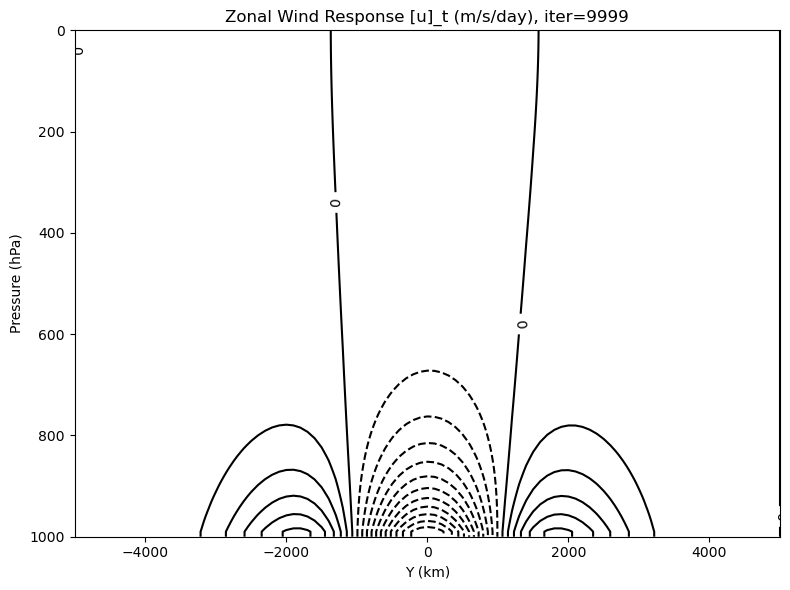

In [58]:
# === Plot result ===
plt.figure(figsize=(8, 6))
cs = plt.contour(y / 1e3, p / 100, u_sor.T * 86400, levels=21, colors='k')
plt.clabel(cs, inline=True)
plt.xlabel('Y (km)')
plt.ylabel('Pressure (hPa)')
plt.title(f'Zonal Wind Response [u]_t (m/s/day), iter={iteration}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [59]:
max_resid

1.2158260913033521e+82

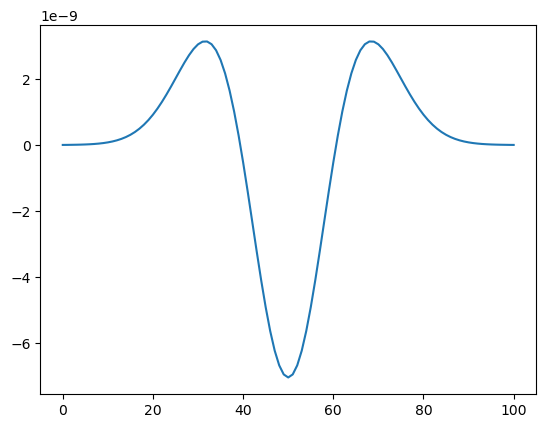

In [61]:
plt.figure()
plt.plot(d2vqb_dy2)

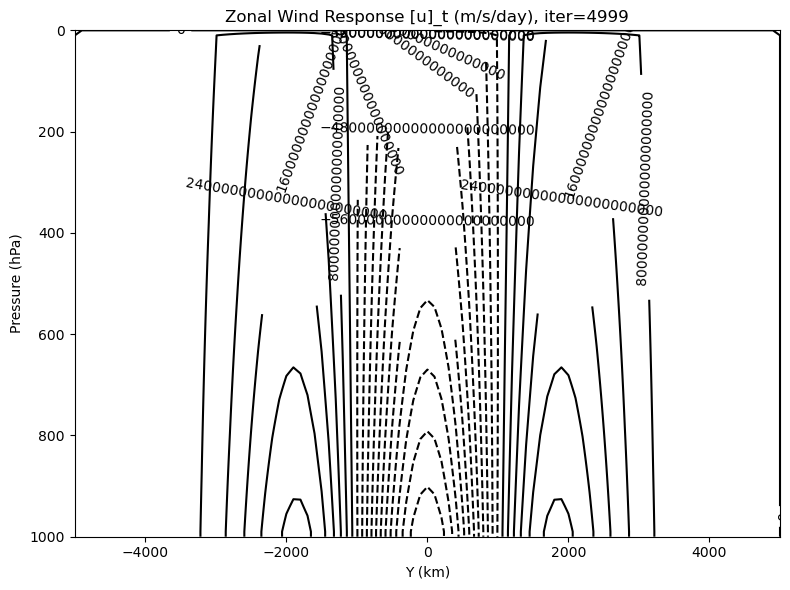

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# === Grid and constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy, dp = y[1] - y[0], p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

f0 = 1e-4
sigma = 1e-5
R = 287
T_b = 280
width = 1500e3

# === Forcing: surface only ===
pb, pt = 1000e2, 200e2
Ab_bottom = 10 * (pb - pt) / 100  # m²/s²
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# === Initialize fields ===
u_sor = np.zeros((ny, nz))
rhs = np.zeros_like(u_sor)
alpha = f0**2 / sigma
omega = 1.2
max_iter = 5000
tolerance = 1e-6
residuals = []

# === SOR with updated boundary & stable vertical structure ===
for iteration in range(max_iter):
    max_resid = 0.0
    for j in range(1, ny - 1):
        # Bottom BC: Eq. (12)
        u0 = u_sor[j, 0]
        u1 = u_sor[j, 1]
        lhs = f0**2 * ((u1 - u0) / (sigma * dp) + pb / (R * T_b) * u0)
        rhs_bc = -d2vqb_dy2[j]
        resid = rhs_bc - lhs
        # Relax only u0 gently
        u0_new = u0 + 0.5 * omega * resid / (f0**2 * (pb / (R * T_b) + 1 / (sigma * dp)))
        u1_new = u0_new + dp * (u1 - u0) / dp  # preserve slope
        u_sor[j, 0] = u0_new
        u_sor[j, 1] = u1_new

        for k in range(2, nz - 1):
            d2udy2 = (u_sor[j+1, k] + u_sor[j-1, k]) / dy**2
            d2udp2 = (u_sor[j, k] + u_sor[j, k-1]) / dp**2  # Neumann top: u[k+1] = u[k]
            denom = 2 / dy**2 + 2 * alpha / dp**2
            u_new = (rhs[j, k] + d2udy2 + alpha * d2udp2) / denom
            resid = u_new - u_sor[j, k]
            u_sor[j, k] += omega * resid
            max_resid = max(max_resid, abs(resid))

    # Lateral boundaries
    u_sor[0, :] = 0
    u_sor[-1, :] = 0

    residuals.append(max_resid)
    if max_resid < tolerance:
        break




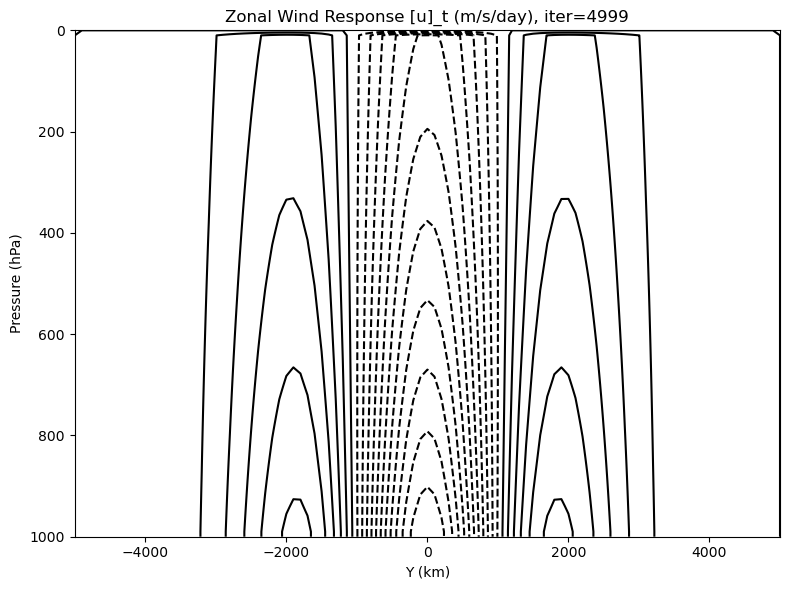

In [64]:
# Plot
plt.figure(figsize=(8, 6))
cs = plt.contour(y / 1e3, p / 100, u_sor.T * 86400, levels=21, colors='k')
# plt.clabel(cs, inline=True)
plt.xlabel('Y (km)')
plt.ylabel('Pressure (hPa)')
plt.title(f'Zonal Wind Response [u]_t (m/s/day), iter={iteration}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [65]:
max_resid

7644431863699200.0

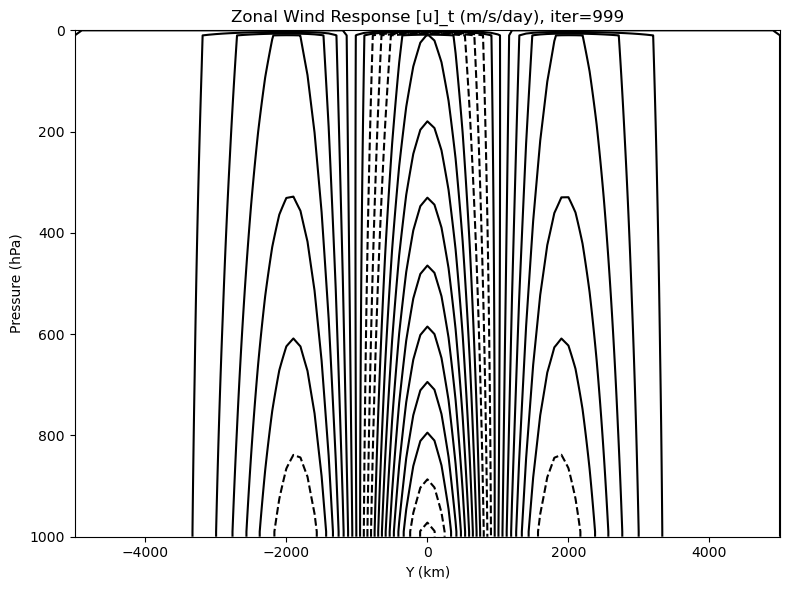

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# === Grid and constants ===
ny, nz = 101, 101
Ly = 5000e3
p_top, p_bot = 0, 1000e2
y = np.linspace(-Ly, Ly, ny)
p = np.linspace(p_bot, p_top, nz)
dy, dp = y[1] - y[0], p[1] - p[0]
Y, P = np.meshgrid(y, p, indexing='ij')

f0 = 1e-4
sigma = 1e-5
R = 287
T_b = 280
width = 1500e3

# === Forcing: surface only ===
pb, pt = 1000e2, 200e2
Ab_bottom = 10 * (pb - pt) / 100  # m²/s²
vqb_b = Ab_bottom * np.exp(-(y / width)**2)
d2vqb_dy2 = np.gradient(np.gradient(vqb_b, dy), dy)

# === Initialize fields ===
u_sor = np.zeros((ny, nz))
rhs = np.zeros_like(u_sor)
alpha = f0**2 / sigma
omega = 1.2
max_iter = 1000
tolerance = 1e-6
residuals = []

# === SOR with Neumann boundaries in y ===
for iteration in range(max_iter):
    max_resid = 0.0
    for j in range(1, ny - 1):
        # Bottom BC: Eq. (12)
        u0 = u_sor[j, 0]
        u1 = u_sor[j, 1]
        lhs = f0**2 * ((u1 - u0) / (sigma * dp) + pb / (R * T_b) * u0)
        rhs_bc = -d2vqb_dy2[j]
        resid = rhs_bc - lhs
        u0_new = u0 + 0.5 * omega * resid / (f0**2 * (pb / (R * T_b) + 1 / (sigma * dp)))
        u1_new = u0_new + dp * (u1 - u0) / dp  # preserve slope
        u_sor[j, 0] = u0_new
        u_sor[j, 1] = u1_new

        for k in range(2, nz - 1):
            d2udy2 = (u_sor[j+1, k] + u_sor[j-1, k]) / dy**2
            d2udp2 = (u_sor[j, k] + u_sor[j, k-1]) / dp**2  # Neumann top: u[k+1] = u[k]
            denom = 2 / dy**2 + 2 * alpha / dp**2
            u_new = (rhs[j, k] + d2udy2 + alpha * d2udp2) / denom
            resid = u_new - u_sor[j, k]
            u_sor[j, k] += omega * resid
            max_resid = max(max_resid, abs(resid))

    # Neumann in y: ∂u/∂y = 0
    u_sor[0, :]  = 0 #u_sor[1, :]
    u_sor[-1, :] = 0 #u_sor[-2, :]

    residuals.append(max_resid)
    if max_resid < tolerance:
        break




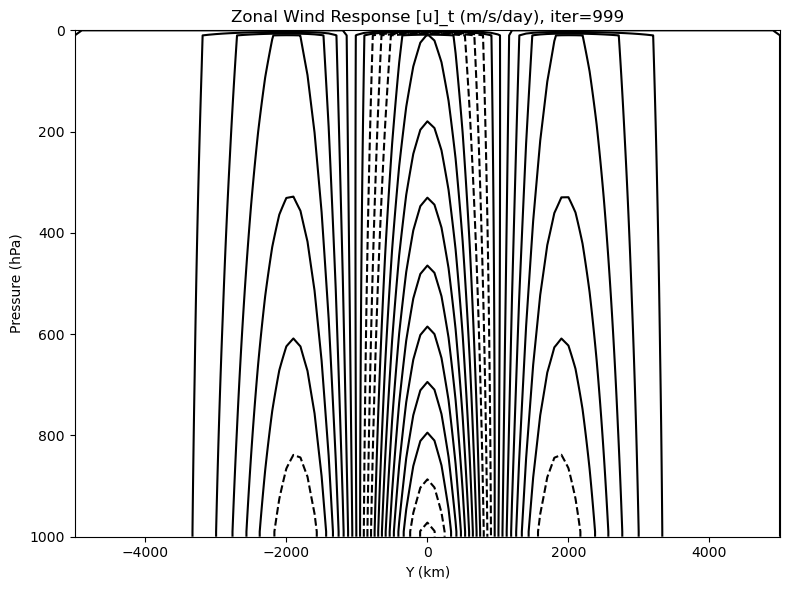

In [73]:
# === Plot ===
plt.figure(figsize=(8, 6))
cs = plt.contour(y / 1e3, p / 100, u_sor.T * 86400, levels=21, colors='k', linestyles=['dashed' if l < 0 else 'solid' for l in np.arange(-3, 8)])
plt.xlabel('Y (km)')
plt.ylabel('Pressure (hPa)')
plt.title(f'Zonal Wind Response [u]_t (m/s/day), iter={iteration}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()